<a href="https://colab.research.google.com/github/jaswanthv99/Image-Classification/blob/main/Image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Download COCO annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip annotations_trainval2014.zip


--2025-01-30 20:29:32--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.41.1, 16.182.70.169, 52.216.170.251, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.41.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip.1’

annotations_trainva 100%[===================>] 241.16M  38.4MB/s    in 6.7s    

2025-01-30 20:29:39 (35.8 MB/s) - ‘annotations_trainval2014.zip.1’ saved [252872794/252872794]

Archive:  annotations_trainval2014.zip
replace annotations/instances_train2014.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace annotations/instances_val2014.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace annotations/person_keypoints_train2014.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace annotations/person_keypoints_val2014.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Download COCO training images (13GB)
!wget http://images.cocodataset.org/zips/train2014.zip
!unzip train2014.zip

# Download COCO validation images (6GB)
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip val2014.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000535608.jpg  
 extracting: val2014/COCO_val2014_000000279145.jpg  
 extracting: val2014/COCO_val2014_000000243495.jpg  
 extracting: val2014/COCO_val2014_000000225791.jpg  
 extracting: val2014/COCO_val2014_000000428067.jpg  
 extracting: val2014/COCO_val2014_000000059383.jpg  
 extracting: val2014/COCO_val2014_000000558498.jpg  
 extracting: val2014/COCO_val2014_000000376123.jpg  
 extracting: val2014/COCO_val2014_000000191304.jpg  
 extracting: val2014/COCO_val2014_000000171062.jpg  
 extracting: val2014/COCO_val2014_000000014549.jpg  
 extracting: val2014/COCO_val2014_000000121152.jpg  
 extracting: val2014/COCO_val2014_000000276596.jpg  
 extracting: val2014/COCO_val2014_000000029431.jpg  
 extracting: val2014/COCO_val2014_000000036349.jpg  
 extracting: val2014/COCO_val2014_000000502055.jpg  
 extracting: val2014/COCO_val2014_000000438848.jpg  
 extracting: val2014/COCO_val2014_000000364973.j

In [ ]:
!pip install pycocotools


loading annotations into memory...
Done (t=3.50s)
creating index...
index created!


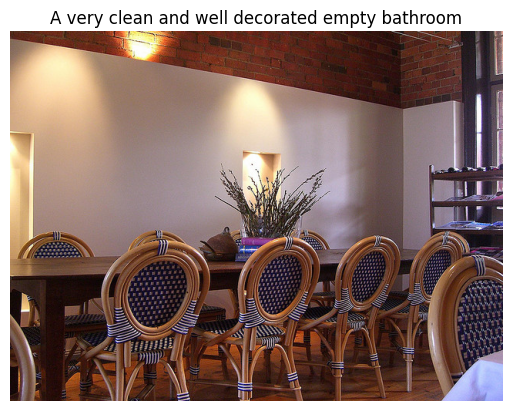

In [ ]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2

# Path to annotations
annotation_file = 'annotations/captions_train2014.json'
coco = COCO(annotation_file)

# Get image IDs and captions
image_ids = coco.getImgIds()
captions = coco.loadAnns(coco.getAnnIds())

# Display a sample image and caption
image_id = image_ids[0]
image_info = coco.loadImgs(image_id)[0]
image_path = f"train2014/{image_info['file_name']}"
caption = captions[0]['caption']

# Load and display the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.title(caption)
plt.show()

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load InceptionV3 model
cnn_model = InceptionV3(include_top=False, weights='imagenet', pooling='avg')

# Function to preprocess images
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Extract features from an image
def extract_features(image_path):
    img = preprocess_image(image_path)
    features = cnn_model.predict(img, verbose=0)
    return features

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize captions
tokenizer = Tokenizer()
all_captions = [caption['caption'] for caption in captions]
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Convert captions to sequences
max_length = 40  # Maximum caption length
sequences = tokenizer.texts_to_sequences(all_captions)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [ ]:
import numpy as np
from tqdm import tqdm

# Prepare data for training
X_images = []
X_text = []
y = []

for i in tqdm(range(len(image_ids))):
    image_id = image_ids[i]
    image_path = f"train2014/{coco.loadImgs(image_id)[0]['file_name']}"
    features = extract_features(image_path)
    X_images.append(features)
    X_text.append(padded_sequences[i])
    y.append(padded_sequences[i])

X_images = np.array(X_images)
X_text = np.array(X_text)
y = np.array(y)

  7%|▋         | 5824/82783 [44:05<9:42:39,  2.20it/s] 


KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# Image feature extractor
inputs1 = Input(shape=(2048,))  # InceptionV3 output size
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Caption sequence input
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Decoder
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Combine the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Train the model
model.fit([X_images, X_text], y, epochs=10, batch_size=64, verbose=1)

In [ ]:
# Function to generate captions
def generate_caption(image_path):
    features = extract_features(image_path)
    caption = '<start>'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        prediction = model.predict([features, sequence], verbose=0)
        predicted_word = tokenizer.index_word[np.argmax(prediction)]
        caption += ' ' + predicted_word
        if predicted_word == '<end>':
            break
    return caption

# Test on a new image
test_image_path = 'test_image.jpg'  # Upload your image to Colab
caption = generate_caption(test_image_path)
print(f"Generated Caption: {caption}")